### NLP with Disaster Tweets

This is a classification project based on the Kaggle Competition 'Natural Language Processing with Disaster Tweets' (found at https://www.kaggle.com/c/nlp-getting-started). It is a supervised learning task where the aim is to tweets as being about real disaster or not.

In [1]:
# First, import all necessary libraries

import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.sparse
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Set random seed to ease comparison

np.random.seed(1000)

In [3]:
# Begin by reading the train and test data in as DataFrames

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# Can see that we have some missing values. Let's check how many.
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
print("Percentage of missing keywords in train set : {}".format(round((61*100)/len(train_df),2)))
print("Percentage of missing locations in train set : {}".format(round((2533*100)/len(train_df),2)))
print("Percentage of missing keywords in test set : {}".format(round((26*100)/len(test_df),2)))
print("Percentage of missing locations in test set : {}".format(round((1105*100)/len(test_df),2)))

Percentage of missing keywords in train set : 0.8
Percentage of missing locations in train set : 33.27
Percentage of missing keywords in test set : 0.8
Percentage of missing locations in test set : 33.86


So both train and test sets are missing less than 1% of data in keywords column, but approximately 33% of the data in the location column is missing.

Next, we can visualise some of the most frequent words using a word cloud. Let's examine the words that appear most for positive targets (i.e. disaster-related tweets)
 
First we will look at the words appearing in the actual tweets.

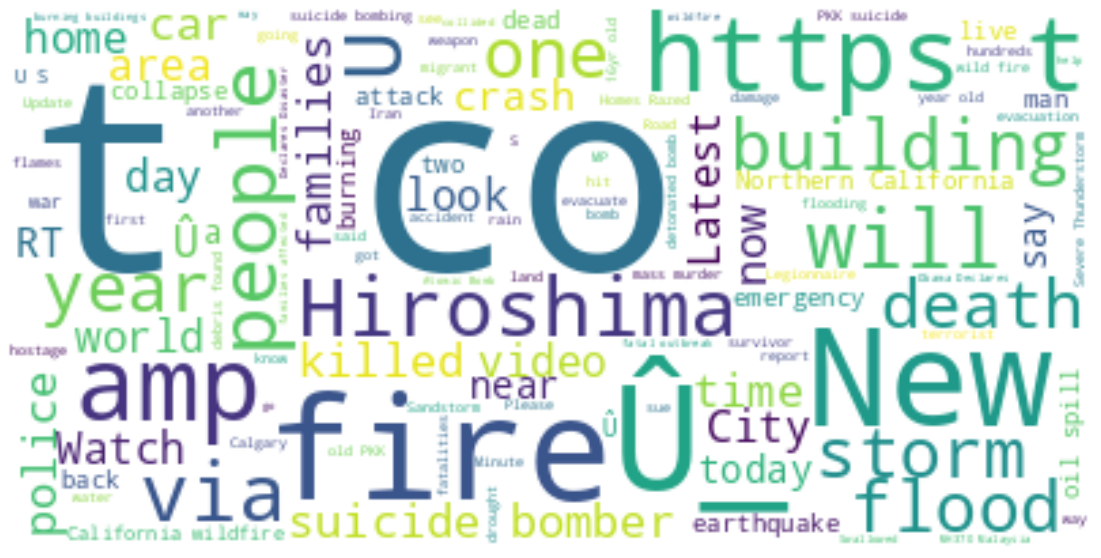

In [9]:
disasters = train_df[train_df.target == 1]
disaster_text = " ".join(tweet for tweet in disasters.text)
text_wc = WordCloud(background_color = "white", max_words = 2000, max_font_size = 100, random_state = 3, 
              stopwords = STOPWORDS, contour_width = 3).generate(disaster_text)
fig = plt.figure(figsize = (20, 10))
plt.imshow(text_wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [10]:
# There are some words that aren't helpful which we can add to the stopwords to improve the word cloud

my_stopwords = set(STOPWORDS)
my_stopwords.update(["t", "https", "U"])

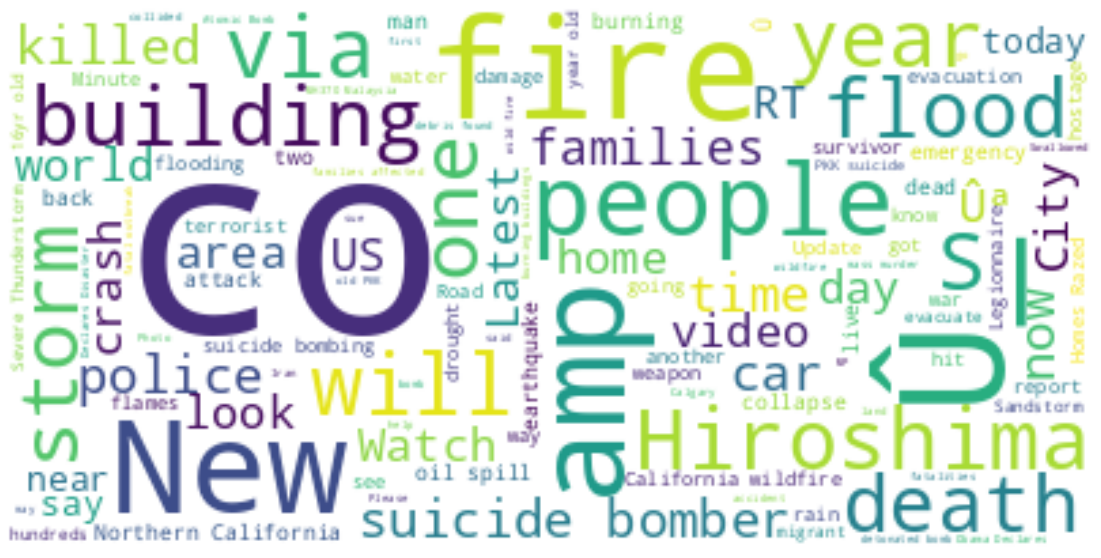

In [11]:
text_wc = WordCloud(background_color = "white", max_words = 2000, max_font_size = 100, random_state = 3, 
              stopwords = my_stopwords, contour_width = 3).generate(disaster_text)
fig = plt.figure(figsize = (20, 10))
plt.imshow(text_wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

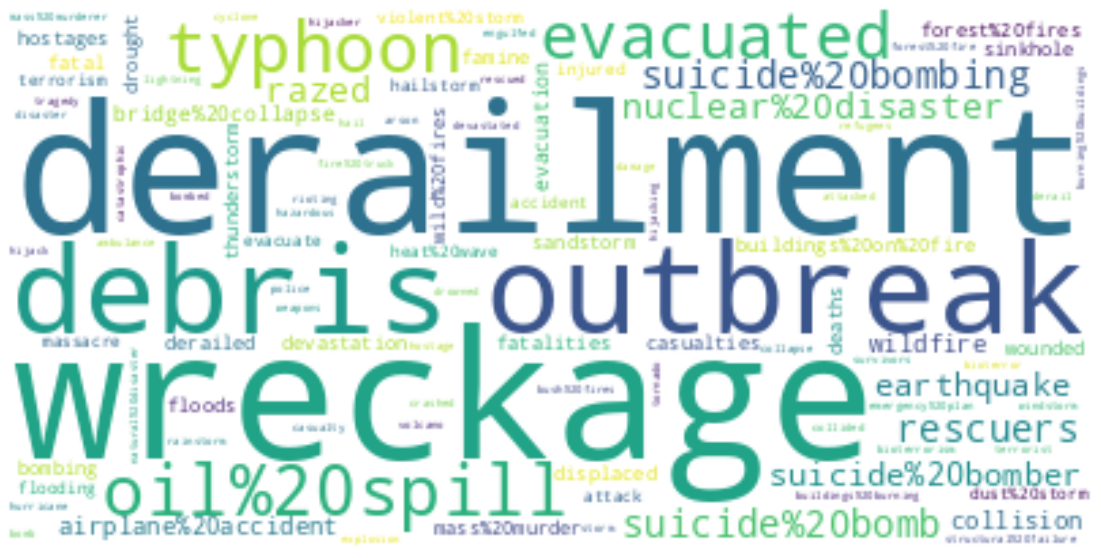

In [12]:
# We can repeat the process with the keywords. First let's filter out the NaN values

filtered = disasters[disasters.keyword.notnull()]
disaster_keywords = filtered.keyword.value_counts()
keyword_wc = WordCloud(background_color = "white", max_words = 2000, max_font_size = 100, random_state = 3, 
              stopwords = my_stopwords, contour_width = 3).generate_from_frequencies(disaster_keywords)
fig = plt.figure(figsize = (20, 10))
plt.imshow(keyword_wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

Many of the most common words are the kinds of words we would associate with disaster, such as 'derailment', 'wreckage', 'fire'. However, there are also a large number of words that could be used in a non-disaster related context, such as 'police', 'storm' etc. This confirms that it will not simply be a case of predicting disasters from some set of keywords.

Let's also have a look at some of the tweets that are disasters.

In [13]:
# First increase display column width to see the full tweet

pd.set_option("max_colwidth", 200)
disasters.text.sample(10)

2451                                    MP train derailment: Village youth saved many lives\nhttp://t.co/lTYeFJdM3A #IndiaTV http://t.co/0La1aw9uUd
894       @TradCatKnight (1) Russia may have played into reason but that link is BS.  Okanowa was bloody and mainline invasion looked like a bloody
3040       #USGS M 0.9 - Northern California: Time2015-08-06 01:50:25 UTC2015-08-06 01:50:25 UTC at epicenter... http://t.co/mBo6OAnIQI #EarthTwerk
5787                                                                       Still rioting in a couple of hours left until I have to be up for class.
2168                     #?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...  http://t.co/q1GlK8plUD
4687                   11:30BST traffic: A10&gt;Paris A40 Geneva A7 Mons A1 Hamburg A2&gt;Hanover A5 Karlsruhe Gotthard n/b  http://t.co/yoi9tOCxiQ
5271                                                   @News@ Refugio oil spill may have been costlier bigger th

In [14]:
# Similalry, we can check some tweets that weren't about disasters

train_df[train_df.target == 0].text.sample(10)

288     RT: ZONEWolf123: I liked a YouTube video http://t.co/u66kYg11ZD Minecraft: NIGHT LUCKY BLOCK MOD (BOB APOCALYPSE WITHER 2.0 &amp; MORE!) MoÛ_
4579                                       A new type of ADHD? Head injuries in children linked to long-term attention problems http://t.co/I4FZ75Utnh
6480                                                        Once upon a time the fact that I decided to go to university 7 hours away actually sunk in
6251           New #photo Oak in a snowstorm http://t.co/JhSCGDA2G8 on the #SouthDowns #Hampshire #Winter #photography #art #tree #treescape #treeporn
1093        Jays rocking #MLB @JoeyBats19 just bombed one out of Rogers Centre. Play-offs r ahead for The #BlueJays - Bell Moseby and Barfield r back!
6026                                                              @marek1330 *Zar cringes at the blows but doesn't let Marek go* *He uses Seismic Toss
4289                                                                            HELLFIRE EP - 

Perhaps there is some correlation between tweet length and whether the tweet is about a disaster or not (in reality this is unlikely, but Kaggle competitions often have peculiarities which can be exploited, so it is worth checking).

In [15]:
# Add the column, then check for correlation

train_df["tweet_length"] = train_df.apply(lambda row: len(row.text), axis=1)
train_df[["target", "tweet_length"]].corr()

,target,tweet_length
target,1.000000,0.181817
tweet_length,0.181817,1.000000


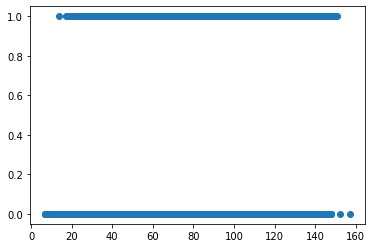

In [16]:
# Visualise any correlation

plt.scatter(train_df.tweet_length, train_df.target)
plt.show()

In [17]:
# As expected, there is no correlation so we can drop this feature

train_df.drop("tweet_length", axis=1, inplace=True)

Now let's move on to modelling. The main indicator of whether a tweet is about a disaster or not is clearly going to be the contents of the tweet itself. There are various ways to analyse text in machine learning. One typical approach is to use Bag of Words to represent a sentence as a vector containing the count of each occurrence of a word. 

Text can be encoded as a Bag of Words using scikit-learn's `CountVectorizer`:

In [18]:
count_vectorizer= CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_df.text)

To start we will try some simple linear models - SGD and Ridge Classifiers. For each model we'll use cross validation with five folds, and then take an average score to evaluate performance. F1 is used as the scoring metric, as this is what is used in the Kaggle competition:

In [19]:
ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, train_vectors, train_df["target"], cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, train_vectors, train_df["target"], cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))

Ridge Classifier average score: 0.57
SGD Classifier average score: 0.59


These scores aren't great. Perhaps we can improve them by using bi-grams, which treats two consecutive words as one 'token' when creating the Bag of Words vectors. This can be helpful in capturing context.

In [20]:
count_vectorizer= CountVectorizer(ngram_range=(2,2))
train_vectors = count_vectorizer.fit_transform(train_df.text)
ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, train_vectors, train_df["target"], cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, train_vectors, train_df["target"], cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))

Ridge Classifier average score: 0.44
SGD Classifier average score: 0.49


This has actually made the models worse. Another option is to let the model use both unigrams and bigrams:

In [21]:
count_vectorizer= CountVectorizer(ngram_range=(1,2))
train_vectors = count_vectorizer.fit_transform(train_df.text)
ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, train_vectors, train_df["target"], cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, train_vectors, train_df["target"], cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))

Ridge Classifier average score: 0.6
SGD Classifier average score: 0.62


This gave a slight improvement, but the scores are still not very impressive.

An alternative method of encoding text for modelling is to use Term Frequency - Inverse Document Frequency (TF-IDF). This gives a measure of how important a word is to a document in a large collection of documents (or in this case, tweets). TF-IDF vectors can be created using scikit-learn's TfidfVectorizer:

In [22]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df.text)
ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, tfidf_train_vectors, train_df["target"], cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, tfidf_train_vectors, train_df["target"], cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))

Ridge Classifier average score: 0.63
SGD Classifier average score: 0.63


This has resulted in a slight improvement. We can also try using bigrams with the tfidf model:

In [23]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df.text)
ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, tfidf_train_vectors, train_df["target"], cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, tfidf_train_vectors, train_df["target"], cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))

Ridge Classifier average score: 0.63
SGD Classifier average score: 0.63


Let's also try Support Vector Classifier and Multinomial Naive Bayes models, which often perform well with text classification tasks. Multinomial Bayes tends to work best with word counts, so we'll use the bag of words vectorizer for these models:

In [24]:
svm_model = LinearSVC()
svm_scores = cross_val_score(svm_model, tfidf_train_vectors, train_df["target"], cv=5, scoring="f1")
nb_model = MultinomialNB()
nb_scores = cross_val_score(nb_model, train_vectors, train_df["target"], cv=5, scoring="f1")

print("SVM Classifier average score: {}".format(round(np.mean(svm_scores),2)))
print("Naive Bayes Classifier average score: {}".format(round(np.mean(nb_scores),2)))

SVM Classifier average score: 0.63
Naive Bayes Classifier average score: 0.67


Naive Bayes is giving the best F1 score so far. Now let's see if we can improve these scores by performing some preprocessing on the text data. I will remove stopwords and punctuation, convert the text to lowercase, and lemmatize each word. Note - CountVectorizer() and TfidfVectorizer() do include lower case conversion and removal of punctuation. They also allow for stopword removal. However, in this case I will perform these steps manually on the data. First I create a copy of the train dataframe to avoid making changes to the original.

In [25]:
pre_train = train_df.copy(deep=True)

# Remove punctuation from the tweets
pre_train.text = pre_train.text.str.replace('[^\w\s]','', regex=True)

# Make all text lower case
pre_train.text = [tweet.lower() for tweet in pre_train.text]

# Tokenise each tweet
pre_train.text = [word_tokenize(tweet) for tweet in pre_train.text]

# Remove stopwords and punctuation
pre_train.text = pre_train.text.apply(lambda x: [word for word in x if word not in my_stopwords])

# Lemmatise each word
# First, create a dictionary mapping the pos tags to the word type
# (defualting to noun if there is no other appropriate tag)
pos_tags = defaultdict(lambda: wordnet.NOUN)
pos_tags['J'] = wordnet.ADJ
pos_tags['V'] = wordnet.VERB
pos_tags['N'] = wordnet.NOUN
pos_tags['R'] = wordnet.ADV

# Next, initialise the lemmatrizer, then use the pos tags dictionary
# to indicate the word type when perfoming the lemmatisation
lemmatizer = WordNetLemmatizer()
for index, tweet in enumerate(pre_train.text):
    results = []
    for word, tag in nltk.pos_tag(tweet):
        result = lemmatizer.lemmatize(word,pos_tags[tag[0]])
        results.append(result)
    pre_train.loc[index, "text"] = str(results)

In [26]:
pre_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']",1
1,4,NaN,NaN,"['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']",1
2,5,NaN,NaN,"['resident', 'ask', 'shelter', 'place', 'notify', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expect']",1
3,6,NaN,NaN,"['13000', 'people', 'receive', 'wildfire', 'evacuation', 'order', 'california']",1
4,7,NaN,NaN,"['get', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pour', 'school']",1


Now that we have created the tokens, we can try modelling again. First using Bag of Words, then TF-IDF.

In [27]:
count_vectorizer= CountVectorizer(ngram_range=(1,2))
count_train_vectors = count_vectorizer.fit_transform(pre_train.text)

ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, count_train_vectors, pre_train.target, cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, count_train_vectors, pre_train.target, cv=5, scoring="f1")
svm_model = LinearSVC()
svm_scores = cross_val_score(svm_model, count_train_vectors, pre_train.target, cv=5, scoring="f1")
nb_model = MultinomialNB()
nb_scores = cross_val_score(nb_model, count_train_vectors, pre_train.target, cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))
print("SVM Classifier average score: {}".format(round(np.mean(svm_scores),2)))
print("Naive Bayes Classifier average score: {}".format(round(np.mean(nb_scores),2)))

Ridge Classifier average score: 0.55
SGD Classifier average score: 0.56
SVM Classifier average score: 0.56
Naive Bayes Classifier average score: 0.67


In [28]:
tfidf_vectorizer= TfidfVectorizer(ngram_range=(1,2))
tfidf_train_vectors = tfidf_vectorizer.fit_transform(pre_train.text)

ridge_model = linear_model.RidgeClassifier()
ridge_scores = cross_val_score(ridge_model, tfidf_train_vectors, pre_train.target, cv=5, scoring="f1")
sgd_model = linear_model.SGDClassifier()
sgd_scores = cross_val_score(sgd_model, tfidf_train_vectors, pre_train.target, cv=5, scoring="f1")
svm_model = LinearSVC()
svm_scores = cross_val_score(svm_model, tfidf_train_vectors, pre_train.target, cv=5, scoring="f1")
nb_model = MultinomialNB()
nb_scores = cross_val_score(nb_model, tfidf_train_vectors, pre_train.target, cv=5, scoring="f1")

print("Ridge Classifier average score: {}".format(round(np.mean(ridge_scores),2)))
print("SGD Classifier average score: {}".format(round(np.mean(sgd_scores),2)))
print("SVM Classifier average score: {}".format(round(np.mean(svm_scores),2)))
print("Naive Bayes Classifier average score: {}".format(round(np.mean(nb_scores),2)))

Ridge Classifier average score: 0.55
SGD Classifier average score: 0.58
SVM Classifier average score: 0.56
Naive Bayes Classifier average score: 0.59


Naive Bayes with Bag of Words gave the best score, although it didn't show any improvement over the non-processed text.

At this stage it is worthwhile submitting a set of predictions to the competition to see how our model is fairing on the test data. First it is necessary to transform the test set in the same way as we did the train set.

In [29]:
pre_test = test_df.copy(deep=True)

# Remove punctuation from the tweets
pre_test.text = pre_test.text.str.replace('[^\w\s]','', regex=True)

# Make all text lower case
pre_test.text = [tweet.lower() for tweet in pre_test.text]

# Tokenise each tweet
pre_test.text = [word_tokenize(tweet) for tweet in pre_test.text]

# Remove stopwords and punctuation
pre_test.text = pre_test.text.apply(lambda x: [word for word in x if word not in my_stopwords])

# Lemmatise each word
lemmatizer = WordNetLemmatizer()
for index, tweet in enumerate(pre_test.text):
    results = []
    for word, tag in nltk.pos_tag(tweet):
        result = lemmatizer.lemmatize(word,pos_tags[tag[0]])
        results.append(result)
    pre_test.loc[index, "text"] = str(results)

Next I join the train and test sets in order to fit the CountVectorizer to the full dataset.

In [30]:
train_X = pre_train.drop('target', axis=1)
train_Y = pre_train.target
full_dataset = pd.concat([train_X, pre_test])

In [31]:
# Fit on the full dataset
count_vectorizer.fit(full_dataset.text)
# Transform the train and test sets
train_X_count = count_vectorizer.transform(train_X.text)
test_X_count = count_vectorizer.transform(pre_test.text)

nb_model = MultinomialNB()
nb_model.fit(train_X_count, train_Y)
# make predictions for test data
y_pred = nb_model.predict(test_X_count)

In [32]:
# Create the submission file

submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_df.target=y_pred
submission_df.set_index("id", inplace=True)
submission_df.to_csv("submission1.csv")

This submission scores 0.80294 on the leaderboard. Perhaps this can be improved upon by using both bag of words and TF-IDF. To do so, I will create two separate representations and then use scipy's `spare.hstack` to join them together.

In [33]:
count_vectorizer= CountVectorizer(ngram_range=(1,2))
count_vectorizer.fit(full_dataset.text)
train_X_count = count_vectorizer.transform(train_X.text)
test_X_count = count_vectorizer.transform(pre_test.text)

tfidf_vectorizer= TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(full_dataset.text)
train_X_tfidf = tfidf_vectorizer.transform(train_X.text)
test_X_tfidf = tfidf_vectorizer.transform(pre_test.text)

# Join the sparse matrices together horizontally
tfidf_count_train = scipy.sparse.hstack([train_X_count, train_X_tfidf])
tfidf_count_test = scipy.sparse.hstack([test_X_count, test_X_tfidf])

nb_model = MultinomialNB()
nb_model.fit(tfidf_count_train,train_Y)
y_pred = nb_model.predict(tfidf_count_test)

In [34]:
submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_df.target=y_pred
submission_df.to_csv("submission2.csv", index=False)

This model using both bag of words and TF-IDF shows a slight improvement, with a score on the leaderboard of 0.81029.

So far the models haven't used the keyword or location features. Regarding the keyword, perhaps there are some keywords which are high indicators of disasters? If so, we could take our model's predictions and then manually correct any tweets that contains these keywords but which the model has classified as non-disasters.

In [35]:
# First create a dataset of just keywords and the respective classification

train_keywords = train_df[['keyword', 'target']].dropna()

# See what keywords are in the dataset 
train_keywords.keyword.unique()

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

From the above we see that some of the keywords contain '%20', which represents a space in HTML. This should be corrected before progressing.

In [36]:
train_keywords.keyword = train_keywords.keyword.str.replace("%20"," ", regex=True)

Next it is necessary to create a measure of strength for each keyword. I will calculate this based on the average value of whether the keyword was associated with a disaster or not (i.e. the average of the target feature, given that this is represented as 1s or 0s).

Once we have this strength measure, we can select all keywords with a strength greater than a certain values, and use these as our indicators of a disaster.

In [37]:
# Create strength score
train_keywords_strength = train_keywords.groupby("keyword").mean('target')

# Get list of keywords with a strength greater than 0.5 (i.e. more than half of the 
# tweets with this keyword were related to disasters)
disaster_keywords_list = train_keywords_strength[train_keywords_strength.target > 0.5].index

# Perform same string replacement on test set and add column indicating
# whether test keyword is present in the list just created
test_df.keyword = test_df.keyword.str.replace("%20"," ", regex=True)
test_df["keyword_in_disasters"] = test_df.keyword.isin(disaster_keywords_list).astype(int)

In [38]:
# Check how many entries in the test set include one of these high scoring keywords

sum(test_df.keyword_in_disasters)

1227

1227 is quite a large number. Could all of these tweets really be about disasters? Let's have a look:

In [39]:
test_df[test_df["keyword_in_disasters"]==1].head()

,id,keyword,location,text,keyword_in_disasters
29,99,accident,"Homewood, PA",Accident cleared in #PaTurnpike on PATP EB between PA-18 and Cranberry slow back to #traffic http://t.co/SL0Oqn0Vyr,1
30,101,accident,NaN,Just got to love burning your self on a damn curling wand... I swear someone needs to take it away from me cuase I'm just accident prone.,1
31,103,accident,NaN,I hate badging shit in accident,1
32,106,accident,USA,#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder Large Re... http://t.co/kKFaSJv6Cj,1
33,108,accident,Massachusetts,Coincidence Or #Curse? Still #Unresolved Secrets From Past http://t.co/7VG8Df9pLE #accident,1


Clearly these are not all disasters. What about if we increase the threshold to 0.75?

In [40]:
disaster_keywords_list_smaller = train_keywords_strength[train_keywords_strength.target > 0.75].index
test_df["keyword_in_disasters_0.75"] = test_df.keyword.isin(disaster_keywords_list_smaller).astype(int)
test_df[test_df["keyword_in_disasters_0.75"] == 1]
print(sum(test_df["keyword_in_disasters_0.75"]))
test_df[test_df["keyword_in_disasters_0.75"]==1].head()

418


,id,keyword,location,text,keyword_in_disasters,keyword_in_disasters_0.75
60,200,airplane accident,"Lake Charles, LA",When carelessness leads to an aviation accident the victim has the right to seek compensation for damages. http://t.co/eqAG6rz1vO,1,1
61,202,airplane accident,"California, USA",@rewind_music found out about you guys today(regarding the accident on the airplane lol) &amp; became a fan! Sending love &amp; support from Cali~?,1,1
62,206,airplane accident,NaN,A girl who died in an airplane accident fifteen years ago,1,1
63,207,airplane accident,NaN,@Mintechan Hihow are you? There is Keio line on the stationright? BTW do you know the airplane accident near Chofu airport this week?,1,1
64,214,airplane accident,"Eagle Pass, Texas",Mexican airplane accident in Ocampo Coahuila MX on 7/29/25 killed Coahuila government SubSecretariat Francisco Garcia Castells age 42.,1,1


418 is still quite a lot, plus again we see in the example above that they are not all disasters. Let's try one more threshold of 0.95:

In [41]:
disaster_keywords_list_smallest = train_keywords_strength[train_keywords_strength.target > 0.95].index
test_df["keyword_in_disasters_0.95"] = test_df.keyword.isin(disaster_keywords_list_smallest).astype(int)
test_df[test_df["keyword_in_disasters_0.95"] == 1]
print(sum(test_df["keyword_in_disasters_0.95"]))
test_df[test_df["keyword_in_disasters_0.95"]==1].head()

105


,id,keyword,location,text,keyword_in_disasters,keyword_in_disasters_0.75,keyword_in_disasters_0.95
940,3103,debris,Seattle,Is a wing part enough to solve the MH370 mystery?: http://t.co/ys2bveKlxK,1,1,1
941,3110,debris,Canada,Debris Found in Indian Ocean could be Malaysia Flight 370! http://t.co/VUoJPrKUAX,1,1,1
942,3113,debris,Rochester Minnesota,BBC News - MH370: Reunion debris is from missing Malaysia flight http://t.co/bze47fzKUd,1,1,1
943,3121,debris,NaN,#news Island Wreckage Is From Missing Malaysian Jet: Officials: Debris found on Reunion Island is from flight ... http://t.co/kRvUmMtVY2,1,1,1
944,3127,debris,Eastbourne East Sussex,Hopefully this will bring some closure for the families #MH370: Malaysian PM confirms debris is from missing flight http://t.co/2963y36LdF,1,1,1


This looks more promising. The next step is to merge the new feature columns with our previous best submission and perform a comparison to see if we have any 'disagreements'. 

In [42]:
submission_df = pd.merge(submission_df, 
                         test_df[["id", "keyword_in_disasters", "keyword_in_disasters_0.75", 
                                  "keyword_in_disasters_0.95"]], on = "id", how='left')

submission_df[submission_df["keyword_in_disasters"]==1]['target'].unique()

array([1, 0])

In [43]:
# We do have some disagreement, so let's make the changes to our previous prediction

submission_df.loc[submission_df["keyword_in_disasters_0.95"]==1, 'target'] = 1
submission_df.drop(["keyword_in_disasters", "keyword_in_disasters_0.75",
                    "keyword_in_disasters_0.95"], inplace=True, axis=1)
submission_df.to_csv("submission3.csv", index=False)

Despite this approach looking promising, the submission scored lower than the previous one, with a score of 0.80753.

Another possibility with the two previously unused columns is that there is some significance to tweets in which the keyword or the location is mentioned in the tweet itself.

In order to investigate this, we will use a filtered version of the dataset to avoid any issues with NaNs.

In [44]:
filtered_keyword = pre_train[pre_train.keyword.notnull()]
filtered_keyword["keyword_in_tweet"] = filtered_keyword.apply(lambda x: x.keyword not in x.text, axis=1).astype(int)
filtered_keyword = filtered_keyword[['id', 'keyword_in_tweet']]
pre_train = pd.merge(pre_train, filtered_keyword, on = "id", how='left')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
# Now repeat for location

filtered_location = pre_train[pre_train.location.notnull()]
filtered_location["location_in_tweet"] = filtered_location.apply(lambda x: x.location not in x.text, axis=1).astype(int)
filtered_location = filtered_location[['id', 'location_in_tweet']]
pre_train = pd.merge(pre_train, filtered_location, on = "id", how='left')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [46]:
# Finally, we can fill the NaN values and check for correlation

pre_train.keyword_in_tweet = pre_train.keyword_in_tweet.fillna(0)
pre_train.location_in_tweet = pre_train.location_in_tweet.fillna(0)

In [47]:
pre_train[["keyword_in_tweet", "target"]].corr()

,keyword_in_tweet,target
keyword_in_tweet,1.000000,0.047944
target,0.047944,1.000000


In [48]:
pre_train[["location_in_tweet", "target"]].corr()

,location_in_tweet,target
location_in_tweet,1.000000,0.007103
target,0.007103,1.000000


There is essentially no correlation here, so the absence or presence of a keyword or location in the text is unlikely to be of any help.

However, my next approach is to test a Gradient Boosting model (specifically XGBoost). Gradient Boosting models are some of the best performing models for both classification and regression problems. They are also relatively simple to instantiate and fast to fit. For this reason, I will leave these two new columns in the dataset.

In order to use both text and non-text features with the XGBoost model, I will convert these columns into a sparse matrix.

In [51]:
extra_columns_sparse = scipy.sparse.csr_matrix(pre_train[["keyword_in_tweet","location_in_tweet"]].values)
final_sparse = scipy.sparse.hstack([train_X_count, train_X_tfidf, extra_columns_sparse])

xgb_model = XGBClassifier(eval_metric='error')
xgb_scores = cross_val_score(xgb_model, final_sparse, train_Y, cv=5, scoring="f1")
print("XGBoost Classifier average score: {}".format(round(np.mean(xgb_scores),2)))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost Classifier average score: 0.48


This model hasn't done very well. Let's remove the two added features to see if it makes a difference:

In [50]:
xgb_model = XGBClassifier(eval_metric='error')
xgb_scores = cross_val_score(xgb_model, tfidf_count_train, train_Y, cv=5, scoring="f1")
print("XGBoost Classifier average score: {}".format(round(np.mean(xgb_scores),2)))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost Classifier average score: 0.49


On this occasion it looks like XGBoost is not suitable for this dataset. Although I may well be able to improve the performance through hyperparameter tuning, it is unlikely that I will be able to get a very high score given the baseline results. Instead, I will investigate a relatively new model known as BERT - Bidirectional Encoder Representations from Transformers. Special thanks to Ari Anastassiou and his excellent Coursera Project for guidance on using BERT- https://www.coursera.org/learn/sentiment-analysis-bert.

The BERT model will use a train-test split to train the model. Before performing the split, we should check how balanced the dataset is, in case it is necessary to perform a stratified split.

In [52]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

The dataset is fairly balanced, and there is no chance of the validation set only containing a single label, so we do not need to use a stratified split.

To make use of the full dataset, I will simply add any keywords and locations to the text of the tweet before passing the whole lot to the BERT model.

In [53]:
train_df = train_df.fillna(' ')
train_df["full_text"] = train_df.keyword+" "+train_df.location+" "+train_df.text

X_train, X_val, y_train, y_val = train_test_split(
    train_df.full_text,
    train_df.target,
    test_size = 0.15,
    random_state=17,
)

In [54]:
# Bert uncased is smaller than cased, and should be suitable for our purposes

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [55]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(
    X_val.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [56]:
# Create the train and validation TensorDatasets

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [57]:
# Define the model

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [58]:
# Define the dataloaders

batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=32
)

In [59]:
# We will use weighted Adam as the optimiser

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

In [60]:
# 10 epochs should be sufficient

epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [61]:
# We define a function to get the f1 score during training

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [62]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [63]:
# Use GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [64]:
# Define a function to evaulate the model during training

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [65]:
# Train the model

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                       leave=False,
                       disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids': batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    torch.save(model.state_dict(), f'/BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\nEpoch: {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 1
Training loss: 0.4840493772564263


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.4350009345346027
F1 Score (weighted): 0.80812359154132


Epoch 2:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 2
Training loss: 0.36379678162007495


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.44748203994499314
F1 Score (weighted): 0.809106830122592


Epoch 3:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 3
Training loss: 0.30856428882611797


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.4440995367864768
F1 Score (weighted): 0.812053128094749


Epoch 4:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 4
Training loss: 0.26185571818883197


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.47965406709247166
F1 Score (weighted): 0.8113465038266813


Epoch 5:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 5
Training loss: 0.22047333841400193


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.5470725980897745
F1 Score (weighted): 0.8119946556527776


Epoch 6:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 6
Training loss: 0.18671412666883375


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.6339558656844828
F1 Score (weighted): 0.8076037574744803


Epoch 7:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 7
Training loss: 0.16318604016098484


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.5930468502144018
F1 Score (weighted): 0.8109029374010367


Epoch 8:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 8
Training loss: 0.14206662506617496


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.6892452107535468
F1 Score (weighted): 0.8061588902786636


Epoch 9:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 9
Training loss: 0.12484587784948314


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.7309394350482358
F1 Score (weighted): 0.8054620321216872


Epoch 10:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 10
Training loss: 0.11829412736347303


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.750486797756619
F1 Score (weighted): 0.7978375829811046


From the training we see that the best performance was actually after the first epoch, so we will load and use that model to make the predictions.

In [66]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [67]:
model.to(device)
pass

In [68]:
model.load_state_dict(
    torch.load('/BERT_ft_epoch1.model',
              map_location=torch.device('cuda')))

<All keys matched successfully>

In [69]:
test_df = test_df.fillna(' ')
test_df["full_text"] = test_df.keyword+" "+test_df.location+" "+test_df.text

In [70]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.full_text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

In [71]:
# Create the TensorDatset for the test data and then define a predict function

dataset_test = TensorDataset(
    input_ids_test, 
    attention_masks_test, 
    )

dataloader_test = DataLoader(
    dataset_test, 
    sampler=SequentialSampler(dataset_test), 
    batch_size=batch_size
    )


def predict(dataloader_test):
  
    model.eval()
    predictions = []
    
    for batch in tqdm(dataloader_test):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    predictions = np.concatenate(predictions, axis=0)

    preds_flat = np.argmax(predictions, axis=1).flatten() 
  
    return preds_flat

In [72]:
# Get test predictions

predictions = predict(dataloader_test)

  0%|          | 0/102 [00:00<?, ?it/s]

In [73]:
submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_df.target=predictions
submission_df.to_csv("submission4.csv", index=False)

This model scored 0.83113 on the leaderboard, which is the best result so far. It may be possible to improve this score further by tuning the hyperparameters of the BERT model. Specifically, I will experiment with different learning rates. The authors of BERT recommend testing the following learning rates:

* 3e-4
* 1e-4
* 5e-5
* 3e-5

I tested each of these learning rates over several epochs and found that the best results came from learning rate 5e-5, after just one epoch (I have not included all of the testing here in order to make the notebook more concise). Therefore, this rate is used below to build the final model.

In [74]:
# Define the model

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [75]:
# Define the dataloaders

batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=32
)

In [76]:
# Set the new learning rate

optimizer = AdamW(
    model.parameters(),
    lr=5e-5,
    eps=1e-8
)

epochs = 1

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [78]:
model.to(device)
pass

In [79]:
# Train the model

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                       leave=False,
                       disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids': batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    torch.save(model.state_dict(), f'/BERT_ft_epoch{epoch}_5e-5.model')
    
    tqdm.write(f'\nEpoch: {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/203 [00:00<?, ?it/s]


Epoch: 1
Training loss: 0.4339436254477853


  0%|          | 0/36 [00:00<?, ?it/s]

Validation loss: 0.4169049287835757
F1 Score (weighted): 0.8219252045466804


In [80]:
predictions = predict(dataloader_test)

  0%|          | 0/102 [00:00<?, ?it/s]

In [81]:
submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_df.target=predictions
submission_df.to_csv("submission5.csv", index=False)

This final model gave the highest score yet, with 0.83481. This gave me a position of 121 on the leaderboard. Given that there was a data leak in this competition, with the actual results being made available online, the first 41 results (perfect scores) should be disregarded. This gives a **true leaderboard position of 80th place**.

Results of each submission are summarised below.

In [82]:
results = pd.DataFrame([['Naive Bayes Count Vectorizer',0.80294], ['Naive Bayes Count Vectorizer + TF-IDF', 0.81029],
                       ['Naive Bayes Count Vectorizer + TF-IDF with manual adjustment', 0.80753], ['BERT 1e-5', 0.83113],
                       ['BERT 5e-5', 0.83481]],
                      columns=['Model', 'F1-Score'])
results

,Model,F1-Score
0,Naive Bayes Count Vectorizer,0.80294
1,Naive Bayes Count Vectorizer + TF-IDF,0.81029
2,Naive Bayes Count Vectorizer + TF-IDF with manual adjustment,0.80753
3,BERT 1e-5,0.83113
4,BERT 5e-5,0.83481


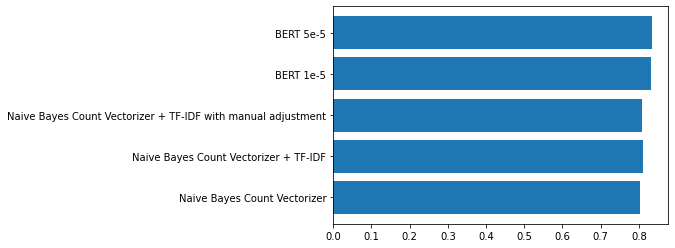

In [83]:
plt.barh(results.Model, results['F1-Score'])
plt.show()